In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import copy
import tensorflow as tf

import os
import time
import numpy as np
from IPython.display import clear_output
import sys
import csv
import math
from matplotlib import colors
import fcn8_new as fcn8_vgg
import csv


ckpt_dir = "/mnt/data3/Game_data/ckpt_dir_8/fcn8_game.ckpt"

PRETRAINED_MODEL_PATH= "/mnt/data3/Game_data/ckpt_dir_8/"

WEIGHT_PATH = '/mnt/data3/Game_data/npy/fcn-game16-epoch-23.npy'

VALSET_PATH2 = '/mnt/data3/Game_data/csv_files/gamedata_val2.csv'

data_csv_path = 'fcn8_game.csv'


NUM_OF_CLASSESS = 19
BATCH_SIZE = 1
IMAGE_HEIGHT1 = 1052
IMAGE_HEIGHT2 = 1046
IMAGE_WIDTH = 1914
NUM_CHANNELS = 3
N_EPOCHS = 1
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


val_csv_file=open(VALSET_PATH2,"r")
val_filepaths=[]
val_labels=[]
val_masks=[]
for line in val_csv_file:
    filepath, label, mask= line.split(",")
    val_filepaths.append(filepath)
    val_labels.append(label)
    val_masks.append(mask.split("\r")[0])
    
val_image_path2, val_label_path2, val_mask_path2 = tf.train.slice_input_producer([val_filepaths,val_labels, val_masks]
                                           ,capacity = 500)
#csv_path = tf.train.string_input_producer([TRAINSET_PATH])
#textReader = tf.TextLineReader()
#_, content = textReader.read(csv_path)
#one_ex = tf.decode_csv(content, record_defaults=[[""], [""], [""]])

val_image_content2 = tf.read_file(val_image_path2)
val_image2 = tf.image.decode_png(val_image_content2, channels=3)
val_image2.set_shape([IMAGE_HEIGHT2, IMAGE_WIDTH, NUM_CHANNELS])
val_image2 = tf.cast(val_image2, tf.float32)

val_label_content2 = tf.read_file(val_label_path2)
val_label2 = tf.image.decode_png(val_label_content2, channels=1)
val_label2.set_shape([IMAGE_HEIGHT2, IMAGE_WIDTH, 1])
val_label2=tf.squeeze(val_label2, squeeze_dims=[2])

#record_bytes=2097152
#reader=tf.FixedLengthRecordReader(record_bytes)
val_mask_content2 =tf.read_file(val_mask_path2)
val_mask2=tf.decode_raw(val_mask_content2,tf.uint8)
val_mask2.set_shape([2002044])
#mask=tf.cast(mask, tf.float32)




val_image_batch2, val_label_batch2, val_mask_batch2= tf.train.batch([val_image2, val_label2, val_mask2], batch_size=BATCH_SIZE,
                                                               capacity=50 + 3 * BATCH_SIZE,
                                                               num_threads=7)





with tf.device('/gpu:0'):
    sess = tf.Session()
    #images_tf = tf.placeholder(tf.float32,[None, 1024, 2048, 3])
    #labels_tf = tf.placeholder(tf.int32,[None, 1024, 2048])
    #masks_tf = tf.placeholder(tf.float32,[None,2097152])
    train_mode = tf.placeholder(tf.bool)
    
    vgg_fcn = fcn8_vgg.FCN8VGG(WEIGHT_PATH)#('./vgg16.npy')
    
    val_image_batch=val_image_batch2
        
    val_label_batch=val_label_batch2
    val_mask_batch=val_mask_batch2
        
        
    images_tf=val_image_batch
    labels_tf=val_label_batch
    masks_tf=val_mask_batch
                          
    with tf.name_scope("content_vgg"):
        vgg_fcn.build(images_tf, train=train_mode, num_classes=19, random_init_fc8=False, debug=False)


    #head=[]
    #sum_of_weights=tf.reduce_sum(weights)
    #labels_oh= tf.one_hot(labels_tf,19)
    
    labels_tf_flat=tf.reshape(tf.mul(tf.reshape(labels_tf,[-1]),masks_tf),[-1])
    #mask_reshped=tf.reshape(masks_tf,[1024,2048])
    #labels_tf_flat2= tf.gather(labels_tf_flat,tf.where(tf.not_equal(labels_tf_flat,19))[1])
    logits = tf.reshape(vgg_fcn.upscore32, (-1, NUM_OF_CLASSESS))
    #logits = tf.gather(logits,tf.where(tf.not_equal(labels_tf_flat,19)))
    labels_tf_flat = tf.cast(labels_tf_flat, tf.int32)

    #epsilon = tf.constant(value=1e-4)
    #logits = logits + epsilon
    #labels_flat_sparse = tf.reshape(labels_oh, (-1, NUM_OF_CLASSESS))
    #labels_flat_sparse=tf.cast(labels_flat_sparse, tf.float64)
    #ww_flat=tf.reshape(weights,[-1])
    #ww_flat = tf.cast(ww_flat, tf.float64)
    #softmax = tf.nn.softmax(logits)
    #softmax = tf.cast(softmax, tf.float64)
    #test1=-tf.reduce_sum(labels_flat_sparse * tf.log(softmax), reduction_indices=[1])
    #test2=tf.reduce_sum(test1)
    #cross_entropy = tf.mul(-tf.reduce_sum(labels_flat_sparse * tf.log(softmax), reduction_indices=[1]),ww_flat)
    #cross_entropy = -tf.reduce_sum(labels_flat_sparse * tf.log(softmax), reduction_indices=[1])
    #mask_flat=tf.reshape(train_mask_batch,[-1])
    masks_tf=tf.cast(masks_tf, tf.float32)
    cross_entropy =tf.mul(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,labels_tf_flat),masks_tf)
    #cross_entropy_sum= tf.reduce_sum(cross_entropy,
    #                                name='xentropy_mean')
    #cross_entropy_mean = tf.reduce_mean(cross_entropy,name='xentropy_mean')
    #cross_entropy_mean = cross_entropy_sum/tf.cast(sum_of_weights, tf.float32)
    cross_entropy_mean = tf.reduce_mean(cross_entropy,
                                        name='xentropy_mean')
    l2_loss=tf.reduce_sum(tf.get_collection("losses"))
    total_loss=cross_entropy_mean +l2_loss
    #loss_tf = tf.reduce_mean((tf.nn.sparse_softmax_cross_entropy_with_logits(vgg_fcn.upscore,
     #                                                                     tf.squeeze(labels_tf, squeeze_dims=[3]),
      #                                                                    name="entropy")))
    
    
    
    
    #train_op = tf.train.MomentumOptimizer(0.0001, 0.99).minimize(cross_entropy_mean)
    train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_mean)
    predictions=tf.argmax(logits, 1)
    #labels_tf_flat=tf.reshape(labels_tf_flat,[-1])
    #labels_flat=tf.cast(labels_tf_flat, tf.int64)
    pred_flat=tf.reshape(predictions,[-1])
with tf.device('/cpu:0'):
    miou,update_cm=tf.contrib.metrics.streaming_mean_iou(pred_flat,labels_tf_flat,19,weights=masks_tf)
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    saver = tf.train.Saver(max_to_keep=150)
with tf.device('/gpu:0'):
    print('Finished building Network.')
    
    init_op = tf.group(tf.initialize_all_variables(),
                       tf.initialize_local_variables())
    sess.run(init_op)
        
    if PRETRAINED_MODEL_PATH:
        print "using Pretrained model"
        ckpt = tf.train.get_checkpoint_state(PRETRAINED_MODEL_PATH)
        print(ckpt)
        saver.restore(sess,ckpt.model_checkpoint_path)
        
    # print(csv_path)
    # For populating queues with batches, very important!
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    
    print("finished")

npy file loaded
Layer name: conv1_1
Layer shape: (3, 3, 3, 64)
Layer name: conv1_2
Layer shape: (3, 3, 64, 64)
Layer name: conv2_1
Layer shape: (3, 3, 64, 128)
Layer name: conv2_2
Layer shape: (3, 3, 128, 128)
Layer name: conv3_1
Layer shape: (3, 3, 128, 256)
Layer name: conv3_2
Layer shape: (3, 3, 256, 256)
Layer name: conv3_3
Layer shape: (3, 3, 256, 256)
Layer name: conv4_1
Layer shape: (3, 3, 256, 512)
Layer name: conv4_2
Layer shape: (3, 3, 512, 512)
Layer name: conv4_3
Layer shape: (3, 3, 512, 512)
Layer name: conv5_1
Layer shape: (3, 3, 512, 512)
Layer name: conv5_2
Layer shape: (3, 3, 512, 512)
Layer name: conv5_3
Layer shape: (3, 3, 512, 512)
Layer name: fc6
Layer shape: [7, 7, 512, 4096]
fc6 dropout_added
Layer name: fc7
Layer shape: [1, 1, 4096, 4096]
fc7 dropout_added
Layer name: fc8
Layer shape: [1, 1, 4096, 19]
Layer name: score_pool4
Layer shape: (1, 1, 512, 19)
Finished building Network.
using Pretrained model
model_checkpoint_path: "/mnt/data3/Game_data/ckpt_dir_8/fcn8

In [3]:
epoch=0

Epoch 1
===========**VALIDATION ACCURACY**================
Validation mIOU:  0.786918
Validation Loss: 0.103798
=================**TIME**====================
Time Elapsed for Epoch:1 is 4.89577173392 minutes


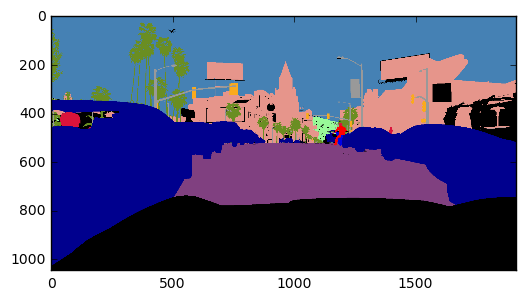

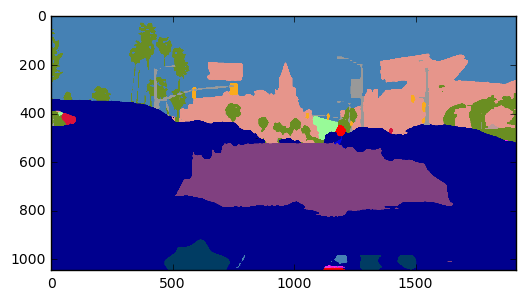

341requesting stop


KeyboardInterrupt: 

In [4]:
total_train_loss_list,train_loss_list,plot_train_loss,plot_total_train_loss,plot_train_miou= [],[],[],[],[]
val_loss_list,plot_val_loss,plot_val_miou= [],[],[]
#for epoch in xrange(N_EPOCHS):
cmap = colors.ListedColormap([[0.4667,0.0431,0.1254],[0.902,0.5882,0.5490],[0,0.2353,0.3921]
                              ,[0,0,0.5569],[0.7451,0.6,0.6],[0,0,0.902]
                              ,[0.8627,0.0784,0.2352],[0.6,0.6,0.6],[1,0,0]
                              ,[0.502,0.251,0.502],[0.9569,0.1372,0.9098],[0.2745,0.5098,0.7059]
                              ,[0.5961,0.9843,0.5961],[0.9804,0.6667,0.1176],[0.8627,0.8627,0]
                              ,[0,0.3137,0.3922],[0,0,0.2745],[0.4196,0.5569,0.1372]
                              ,[0.4,0.4,0.6118],[0,0,0]])
norm=colors.NoNorm(0,19)
try:
    while not coord.should_stop() and epoch< N_EPOCHS:
        epoch+=1
        epoch_start_time = time.time()
        
        for iteration in xrange(500/BATCH_SIZE): 
            if (iteration%500==0):
                val_loss,_,val_pred_pic, val_label_pic = sess.run([cross_entropy_mean,
                                                            update_cm,vgg_fcn.pred_up,labels_tf],feed_dict={train_mode: False})
                plt.figure(1)
                plt.imshow(val_label_pic[0],cmap=cmap,norm=norm)
                plt.figure(2)
                plt.imshow(val_pred_pic[0],cmap=cmap,norm=norm)
                #plt.figure(3)
                #plt.imshow(output2[0],cmap=cmap,norm=norm)
                plt.show()
            else:
                    val_loss,confusion = sess.run([cross_entropy_mean,update_cm],feed_dict={train_mode: False})
            val_loss_list.append(val_loss)
            sys.stdout.write('\r\r' + str(iteration))
            sys.stdout.flush()
        
            
        val_iou=sess.run(miou)    
        val_loss_mean = np.mean(val_loss_list)
        plot_val_loss.append(val_loss_mean)
        
        val_loss_list = []
        plot_val_miou.append(val_iou)
        
        var_miou = filter(lambda x: x.name.endswith('total_confusion_matrix:0'), tf.local_variables())
        init_miou=tf.initialize_variables(var_miou)
        sess.run(init_miou)
        
        clear_output()
        print "Epoch", epoch
        
        print "===========**VALIDATION ACCURACY**================"
        print 'Validation mIOU: ', val_iou
        print "Validation Loss:", val_loss_mean 
        
        print "=================**TIME**===================="
        print 'Time Elapsed for Epoch:' + str(epoch) + ' is ' + str(
                (time.time() - epoch_start_time) / 60.) + ' minutes'
    
except tf.errors.OutOfRangeError:
    print ("out of range")
finally:
    coord.request_stop()
    coord.join(threads)
    print("requesting stop")
        #print(iou[1])
            #train_loss= sess.run(vgg_fcn.upscore,
             #   feed_dict={ images_tf: train_imbatch})
            #res=sess.run(image)
            #plt.imshow(train_labatch[0])
            #plt.show()
    #    aa= tt * np.log10(train_loss)
    #    print(len(aa))
    #    print(len(aa[0]))
    #print(sum)
    #print(sum2)
    #print(len(ww))
    #print(len(ww[0]))
    #print(len(ww[0][0]))




In [ ]:
data_csv_path = 'metrics_fcn8_game.csv'
row_sum=np.sum(confusion,axis=0)
col_sum=np.sum(confusion,axis=1)
#print(row_sum)
#print(col_sum)

class_miou=[0 for x in range(19)]
class_percision=[0 for x in range(19)]
class_recall=[0 for x in range(19)]
for i in xrange(len(confusion[0])):
    #print(confusion[i][i])
    class_miou[i]=(float(confusion[i][i])/float((row_sum[i]+col_sum[i]-confusion[i][i])))
    class_recall[i]=(float(confusion[i][i])/float(row_sum[i]))
    class_percision[i]=(float(confusion[i][i])/float(col_sum[i]))

ofile  = open(data_csv_path, "w")
writer = csv.writer(ofile)
for i in range(len(class_miou)):
    writer.writerow([i,class_miou[i],class_recall[i],class_percision[i]])
ofile.close()    
print(class_miou)